In [1]:
import db_helpers as dbh
import db_parse as dbp
import json
import pandas as pd
from pprint import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [2]:
data_dir = "data"
revision = "test"
do_wipe = False
do_import = False
do_describe = False

In [3]:
conn = dbh.Connection("dos")
if do_describe:
    print(f"Connected to database: {conn.db_name()}")
    conn.describe()
    conn.row_counts()
    conn.db_query("select distinct metric from data")

In [4]:
# revision_id = conn.nickname_id("revisions", revision)
# materialization_id = conn.nickname_id("materializations", materialization)
# session_id = dbh.result_as_value(conn.db_query("select id from sessions where nickname='{}'".format(session)))

In [5]:
df = pd.DataFrame(
    conn.db_query(
    """
    SELECT
        hostname,
        hostnum::int AS Client,
        (settings->>'attack_type') AS attack_type,
        (settings->>'mitigation') AS Mitigation,
        (settings->>'bottleneck_capacity')::int,
        (settings->>'bottleneck_latency')::int,
        (settings->>'bottleneck_loss')::float,
        (settings->>'client_interval')::float,
        (settings->>'mitigated_attack_type') AS mitigated_attack,
        (settings->>'syn_pow_verifier') AS Verifier,
        (settings->>'n_attackers')::int AS Attackers,
        (settings->>'client_app') AS client_app,
        (settings->>'file_size') AS file_size,
        (settings->>'attacker_busywait')::int AS busywait,
        (settings->>'attacker_cpu_limit')::int AS attacker_cpu_limit,
        metric,
        ub,
        mb,
        ua,
        ma,
        efficacy,
        overhead,
        threat,
        damage,
        efficacy_pct,
        efficacy_pct_threat,
        efficacy_relative,
        overhead_pct,
        threat_pct,
        damage_pct
    FROM results
    JOIN experiments ON results.experiment = experiments.id
    JOIN hosts ON results.host = hosts.id
    JOIN sessions ON experiments.session = sessions.id
    WHERE
        (sessions.nickname IN ('quic_loss'))
    """
    ), columns=["Hostname", "Client", "Attack", "Mitigation", "Bottleneck Capacity", "Bottleneck Latency", "Bottleneck Loss",
                "Client Delay", "Mitigated Attack", "Verifier", "Attackers", "Client Application", "File Size",
                "Attacker Busywait", "Attacker CPU Limit", "Metric", "UB", "MB", "UA", "MA",
                "Efficacy", "Overhead", "Threat", "Damage", "Efficacy Percent", "Efficacy Percent Threat",
                "Relative Efficacy", "Overhead Percent", "Threat Percent", "Damage Percent"]
)

In [6]:
mitigation_k_map = {
    'syn_pow_0': 0,
    'syn_pow_8': 8,
    'syn_pow_32': 32,
    'syn_pow_64': 64,
    'syn_pow_256': 256,
    'syn_pow_1024': 1024
}
df["Client/Server k"] = df["Mitigation"].map(mitigation_k_map)

mitigation_map = {
    'syn_pow_0': 'eBPF No-Op',
    'syn_pow_8': 'SYN PoW (k=8)',
    'syn_pow_32':'SYN PoW (k=32)',
    'syn_pow_64': 'SYN PoW (k=64)',
    'syn_pow_256': 'SYN PoW (k=256)',
    'syn_cookies': 'SYN Cookies',
    'syn_pow_8_cookies': 'SYN Cookies + PoW (k=8)',
    'syn_pow_64_cookies': 'SYN Cookies + PoW (k=64)',
    'syn_pad': 'SYN Padding',
    'syn_pad_cookies': 'SYN Cookies + Padding',
    'quic_retry': 'QUIC Retry'
}
df["DoS Mitigation"] = df["Mitigation"].map(mitigation_map)

mitigated_attack_k_map = {
    'syn_flood': 0,
    'syn_flood_pow_8': 8,
    'syn_flood_pow_32': 32,
    'syn_flood_pow_64': 64,
    'syn_flood_pow_256': 256,
    'syn_flood_pow_1024': 1024
}
df["Attacker k"] = df["Mitigated Attack"].map(mitigated_attack_k_map)

flood_type_map = {
    'syn_flood': 'Dumb',
    'syn_flood_pow_8': 'Smart',
    'syn_flood_pow_32': 'Smart',
    'syn_flood_pow_64': 'Smart',
    'syn_flood_pow_256': 'Smart',
    'syn_flood_pow_1024': 'Smart',
    'syn_flood_padded': 'Smart'
}

attack_map = {
    'syn_flood': 'TCP SYN',
    'quic_prebuilt': 'QUIC Initial'
}
df["Flood Type"] = df["Mitigated Attack"].map(attack_map)#(flood_type_map)



client_app_map = {
    'tcp': 'TCP Setup',
    'http': 'HTTP',
    'https': 'HTTPS',
    'http2': 'HTTPS 2',
    'http3': 'HTTP3/QUIC',
}
df["Application"] = df["Client Application"].map(client_app_map)

client_location_map = {
    0: 'A',
    1: 'A',
    2: 'A',
    3: 'B',
    4: 'B',
    5: 'B',
    6: 'C',
    7: 'C',
    8: 'C',
    9: 'D',
    10: 'D',
    11: 'D',
}
df["Client Subnet"] = df["Client"].map(client_location_map)
df["Client Location"] = df["Client Subnet"].map({
    'A': 'LAN',
    'B': 'Local',
    'C': 'Remote',
    'D': 'Sink'
})
# attacker_k_map = {
#     'syn_flood': 0,
#     'syn_flood_pow_8': 8,
#     'syn_flood_pow_32': 32
# }
# df["Attacker k"] = df["Mitigated Attack"].map(attacker_k_map)

verifier_map = {
    's0': 'Server',
    'firewall': 'Firewall',
    'edge_router': 'Edge Routers'
}
df["Verifier Location"] = df["Verifier"].map(verifier_map)

df["Attack Strength"] = df["Attackers"] * 0.01 * df["Attacker CPU Limit"]

# mitigation_map = {
#     'syn_pad': 'SYN Padding',
#     'syn_pow_8': 'SYN PoW (k=8)',
#     'syn_pow_64': 'SYN PoW (k=64)'
# }
# df["Mitigation Approach"] = df["Mitigation"].map(verifier_map)

In [7]:
# Variables

for col in df:
    if col not in ['UB', 'UA', 'MB', 'MA', 'Threat', 'Damage', 'Efficacy', 'Overhead', 'Threat Percent', 'Damage Percent', 'Efficacy Percent', 'Efficacy Percent Threat', 'Relative Efficacy', 'Overhead Percent']:
        print("{}: {}".format(col, df[col].unique()))

Hostname: ['c10' 'c0' 'c5' 'c6' 'c8' 'c4' 'c9' 'c11' 'c3' 'c2' 'c7' 'c1']
Client: [10  0  5  6  8  4  9 11  3  2  7  1]
Attack: ['quic_prebuilt' 'syn_flood']
Mitigation: ['quic_retry' 'syn_cookies']
Bottleneck Capacity: [1000  500]
Bottleneck Latency: [1]
Bottleneck Loss: [0.   0.01 0.1 ]
Client Delay: [0.]
Mitigated Attack: ['quic_prebuilt' 'syn_flood']
Verifier: ['s0']
Attackers: [4]
Client Application: ['https' 'http3' 'http']
File Size: ['1M' '10K' '1K' '100K']
Attacker Busywait: [0]
Attacker CPU Limit: [100]
Metric: ['Transaction Duration' 'Transaction Status' 'Transactions per Second']
Client/Server k: [nan]
DoS Mitigation: ['QUIC Retry' 'SYN Cookies']
Attacker k: [nan  0.]
Flood Type: ['QUIC Initial' 'TCP SYN']
Application: ['HTTPS' 'HTTP3/QUIC' 'HTTP']
Client Subnet: ['D' 'A' 'B' 'C']
Client Location: ['Sink' 'LAN' 'Local' 'Remote']
Verifier Location: ['Server']
Attack Strength: [4.]


In [80]:
application_order = ["HTTP", "HTTPS", "HTTP3/QUIC"]
location_order = ['LAN', 'Local', 'Remote', 'Sink']
df_plt = df.loc[
    (df['Metric'] == 'Transaction Duration') & #['Transaction Duration' 'Transactions per Second']
    (df['Application']).isin(application_order) &
    (df['File Size'].isin(['1K'])) & #['1K' '10K']
    (df['Bottleneck Capacity'].isin([1000])) & #[1000 500]
    (df['Bottleneck Loss'].isin([0.0])) & #[0.0 0.01 0.1]
    (df['DoS Mitigation'].isin(['QUIC Retry'])) & #['QUIC Retry' 'SYN Cookies']
    (df['Flood Type'].isin(['QUIC Initial'])) #['QUIC Initial' 'TCP SYN']
]

Text(0, 0.5, 'Transaction Duration (s)')

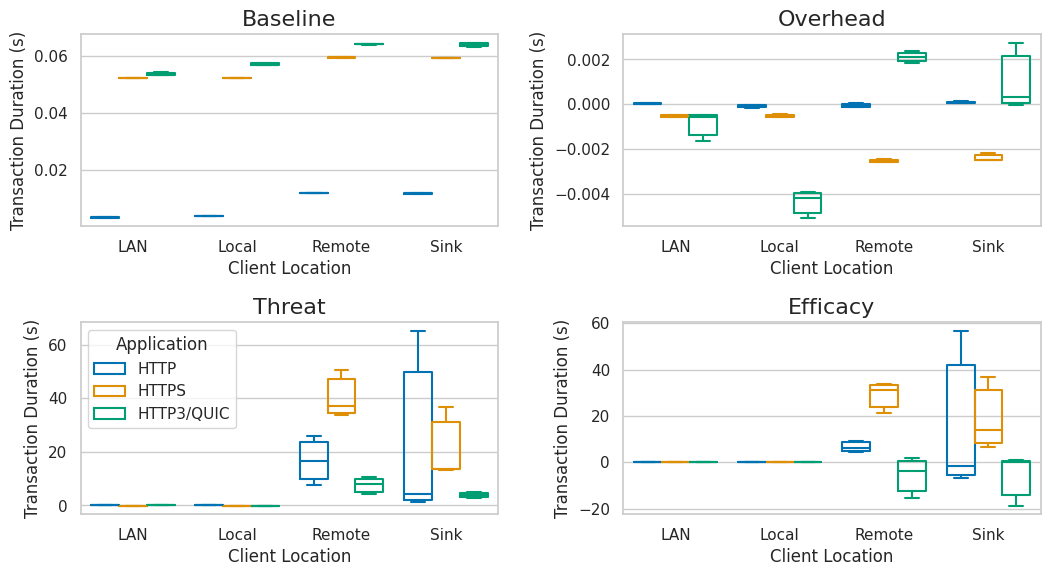

In [81]:
# Draw Plots
sns.set(style="whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False, sharey=False)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1,  # Adjust the left margin
                    right=0.9,  # Adjust the right margin
                    bottom=0.1,  # Adjust the bottom margin
                    top=0.9,     # Adjust the top margin
                    wspace=0.3,  # Adjust the width space between subplots
                    hspace=0.5)  # Adjust the height space between subplots


sns.boxplot(
    ax=ax1,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order,
    fill=False,
    legend=None
)

sns.boxplot(
    ax=ax2,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Overhead',
    palette='colorblind',
    hue_order=application_order,
    legend=None,
    fill=False
)

sns.boxplot(
    ax=ax3,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Threat',
    palette='colorblind',
    hue_order=application_order,
    # legend=None,
    fill=False
)

sns.boxplot(
    ax=ax4,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='Efficacy',
    palette='colorblind',
    hue_order=application_order,
    legend=None,
    fill=False
)

ax1.set_title('Baseline', fontsize=16)
ax1.set_ylabel('Transaction Duration (s)')
ax2.set_title('Overhead', fontsize=16)
ax2.set_ylabel('Transaction Duration (s)')
# ax2.set_ylim(-100, 100)
ax3.set_title('Threat', fontsize=16)
ax3.set_ylabel('Transaction Duration (s)')
# ax3.set_ylim(-100, 100)
ax4.set_title('Efficacy', fontsize=16)
ax4.set_ylabel('Transaction Duration (s)')
# ax4.set_ylim(-100, 100)

Text(0, 0.5, 'Transaction Duration (s)')

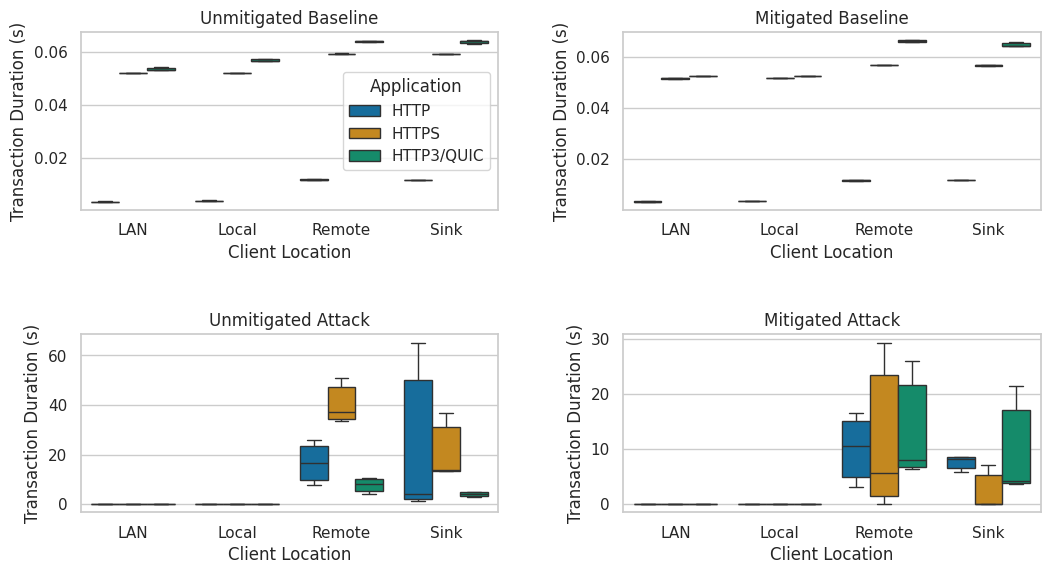

In [82]:
# Draw Plots

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False, sharey=False)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1,  # Adjust the left margin
                    right=0.9,  # Adjust the right margin
                    bottom=0.1,  # Adjust the bottom margin
                    top=0.9,     # Adjust the top margin
                    wspace=0.3,  # Adjust the width space between subplots
                    hspace=0.7)  # Adjust the height space between subplots


sns.boxplot(
    ax=ax1,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='UB',
    palette='colorblind',
    hue_order=application_order,
)

sns.boxplot(
    ax=ax2,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='MB',
    palette='colorblind',
    hue_order=application_order,
    legend=None
)

sns.boxplot(
    ax=ax3,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='UA',
    palette='colorblind',
    hue_order=application_order,
    legend=None
)

sns.boxplot(
    ax=ax4,
    data=df_plt,
    x='Client Location',
    order=location_order,
    hue='Application',
    y='MA',
    palette='colorblind',
    hue_order=application_order,
    legend=None
)

ax1.set_title('Unmitigated Baseline')
ax1.set_ylabel('Transaction Duration (s)')
ax2.set_title('Mitigated Baseline')
ax2.set_ylabel('Transaction Duration (s)')
# ax2.set_ylim(-100, 100)
ax3.set_title('Unmitigated Attack')
ax3.set_ylabel('Transaction Duration (s)')
# ax3.set_ylim(-100, 100)
ax4.set_title('Mitigated Attack')
ax4.set_ylabel('Transaction Duration (s)')
# ax4.set_ylim(-100, 100)